# Initialization

A well chosen initialization can:
- Speed up the convergence of gradient descent
- Increase the odds of gradient descent converging to a lower training (and generalization) error 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

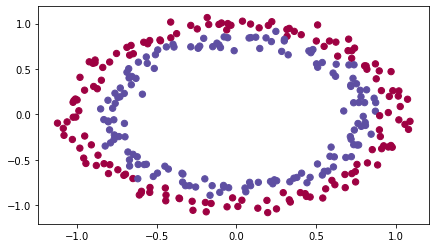

In [4]:
# load image dataset: blue/red dots in circles
train_X, train_Y, test_X, test_Y = load_dataset()

## 1 - Neural Network model 

- *Zeros initialization* --  setting `initialization = "zeros"` in the input argument.
- *Random initialization* -- setting `initialization = "random"` in the input argument. This initializes the weights to large random values.  
- *He initialization* -- setting `initialization = "he"` in the input argument. This initializes the weights to random values scaled according to a paper by He et al., 2015.

In [27]:
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

In [28]:
def relu(x):
    """
    Compute the relu of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- relu(x)
    """
    s = np.maximum(0,x)
    
    return s

In [29]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
        
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

In [30]:
def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

In [31]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of n_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters['W' + str(i)] = ... 
                  parameters['b' + str(i)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(L):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

In [32]:
def compute_loss(a3, Y):
    
    """
    Implement the loss function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    loss - value of the loss function
    """
    
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    loss = 1./m * np.nansum(logprobs)
    
    return loss

In [33]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [34]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [35]:
def model(X, Y, learning_rate = 0.01, num_iterations = 15000, print_cost = True, initialization = "he"):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (containing 0 for red dots; 1 for blue dots), of shape (1, number of examples)
    learning_rate -- learning rate for gradient descent 
    num_iterations -- number of iterations to run gradient descent
    print_cost -- if True, print the cost every 1000 iterations
    initialization -- flag to choose which initialization to use ("zeros","random" or "he")
    
    Returns:
    parameters -- parameters learnt by the model
    """
        
    grads = {}
    costs = [] # to keep track of the loss
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0], 10, 5, 1]
    
    # Initialize parameters dictionary.
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        a3, cache = forward_propagation(X, parameters)
        
        # Loss
        cost = compute_loss(a3, Y)

        # Backward propagation.
        grads = backward_propagation(X, Y, cache)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)
            
    # plot the loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## 2 - Zero initialization

There are two types of parameters to initialize in a neural network:
- the weight matrices $(W^{[1]}, W^{[2]}, W^{[3]}, ..., W^{[L-1]}, W^{[L]})$
- the bias vectors $(b^{[1]}, b^{[2]}, b^{[3]}, ..., b^{[L-1]}, b^{[L]})$

In [36]:
def initialize_parameters_zeros(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    parameters = {}
    L = len(layers_dims)            # number of layers in the network
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.zeros((layers_dims[l], layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
    return parameters

In [37]:
parameters = initialize_parameters_zeros([3,2,1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[0. 0. 0.]
 [0. 0. 0.]]
b1 = [[0.]
 [0.]]
W2 = [[0. 0.]]
b2 = [[0.]]


Cost after iteration 0: 0.6931471805599453
Cost after iteration 1000: 0.6931471805599453
Cost after iteration 2000: 0.6931471805599453
Cost after iteration 3000: 0.6931471805599453
Cost after iteration 4000: 0.6931471805599453
Cost after iteration 5000: 0.6931471805599453
Cost after iteration 6000: 0.6931471805599453
Cost after iteration 7000: 0.6931471805599453
Cost after iteration 8000: 0.6931471805599453
Cost after iteration 9000: 0.6931471805599453
Cost after iteration 10000: 0.6931471805599455
Cost after iteration 11000: 0.6931471805599453
Cost after iteration 12000: 0.6931471805599453
Cost after iteration 13000: 0.6931471805599453
Cost after iteration 14000: 0.6931471805599453


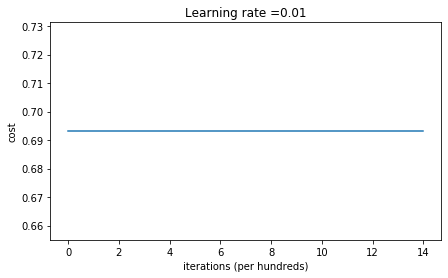

On the train set:
Accuracy: 0.5
On the test set:
Accuracy: 0.5


In [38]:
parameters = model(train_X, train_Y, initialization = "zeros")
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

In [39]:
print ("predictions_train = " + str(predictions_train))
print ("predictions_test = " + str(predictions_test))

predictions_train = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]
predictions_test = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


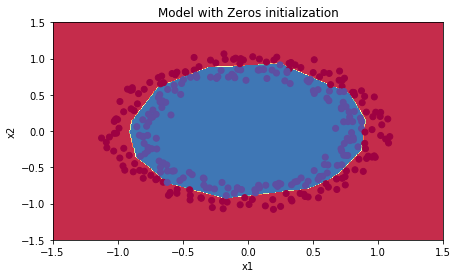

In [51]:
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.reshape(train_Y.shape[1]))

- Initializing all the weights to zero results in the network failing to break symmetry. This means that every neuron in each layer will learn the same thing
- Train a neural network with $n^{[l]}=1$ for every layer, yet the network will be no more powerful than a linear classifier such as logistic regression

## 3 - Random initialization

- The weights $W^{[l]}$ should be initialized randomly to break symmetry. 
- It is however okay to initialize the biases $b^{[l]}$ to zeros. Symmetry is still broken so long as $W^{[l]}$ is initialized randomly. 

In [41]:
def initialize_parameters_random(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)               # This seed makes sure your "random" numbers will be the as ours
    parameters = {}
    L = len(layers_dims)            # integer representing the number of layers
    
    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 10
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        ### END CODE HERE ###

    return parameters

In [42]:
parameters = initialize_parameters_random([3, 2, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 17.88628473   4.36509851   0.96497468]
 [-18.63492703  -2.77388203  -3.54758979]]
b1 = [[0.]
 [0.]]
W2 = [[-0.82741481 -6.27000677]]
b2 = [[0.]]


C:\Users\Rieh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
C:\Users\Rieh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


Cost after iteration 0: inf
Cost after iteration 1000: 0.6250982793959966
Cost after iteration 2000: 0.5981216596703697
Cost after iteration 3000: 0.5638417572298645
Cost after iteration 4000: 0.5501703049199763
Cost after iteration 5000: 0.5444632909664456
Cost after iteration 6000: 0.5374513807000807
Cost after iteration 7000: 0.4764042074074983
Cost after iteration 8000: 0.39781492295092263
Cost after iteration 9000: 0.3934764028765484
Cost after iteration 10000: 0.3920295461882659
Cost after iteration 11000: 0.38924598135108
Cost after iteration 12000: 0.3861547485712325
Cost after iteration 13000: 0.384984728909703
Cost after iteration 14000: 0.3827828308349524


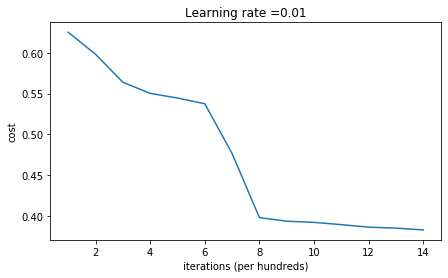

On the train set:
Accuracy: 0.83
On the test set:
Accuracy: 0.86


In [43]:
parameters = model(train_X, train_Y, initialization = "random")
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

In [44]:
print (predictions_train)
print (predictions_test)

[[1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1
  1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0
  0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0
  1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0
  0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1
  1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1
  0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1
  1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1
  1 1 1 1 0 0 0 1 1 1 1 0]]
[[1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 1
  0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0
  1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0]]


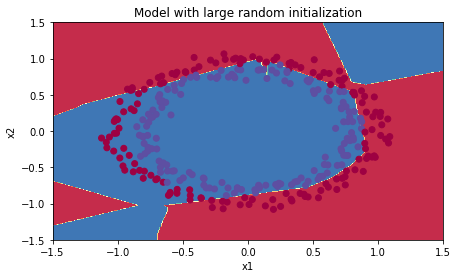

In [45]:
plt.title("Model with large random initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.reshape(train_Y.shape[1]))

- Initializing weights to very large random values does not work well
- Hopefully intializing with small random values does better

## 4 - He initialization

He initialization uses `sqrt(2./layers_dims[l-1])`, which is similar to Xavier initialization with a scaling factor for the weights $W^{[l]}$ of `sqrt(1./layers_dims[l-1])`

In [46]:
def initialize_parameters_he(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 # integer representing the number of layers
     
    for l in range(1, L + 1):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2 / layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        ### END CODE HERE ###
        
    return parameters

In [47]:
parameters = initialize_parameters_he([2, 4, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]
 [-0.08274148 -0.62700068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.03098412 -0.33744411 -0.92904268  0.62552248]]
b2 = [[0.]]


Cost after iteration 0: 0.8830537463419761
Cost after iteration 1000: 0.6879825919728063
Cost after iteration 2000: 0.6751286264523371
Cost after iteration 3000: 0.6526117768893807
Cost after iteration 4000: 0.6082958970572937
Cost after iteration 5000: 0.5304944491717495
Cost after iteration 6000: 0.4138645817071793
Cost after iteration 7000: 0.3117803464844441
Cost after iteration 8000: 0.23696215330322556
Cost after iteration 9000: 0.18597287209206828
Cost after iteration 10000: 0.15015556280371808
Cost after iteration 11000: 0.12325079292273548
Cost after iteration 12000: 0.09917746546525937
Cost after iteration 13000: 0.08457055954024274
Cost after iteration 14000: 0.07357895962677366


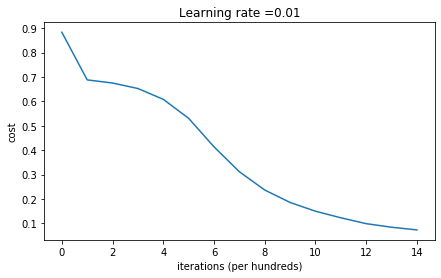

On the train set:
Accuracy: 0.9933333333333333
On the test set:
Accuracy: 0.96


In [48]:
parameters = model(train_X, train_Y, initialization = "he")
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

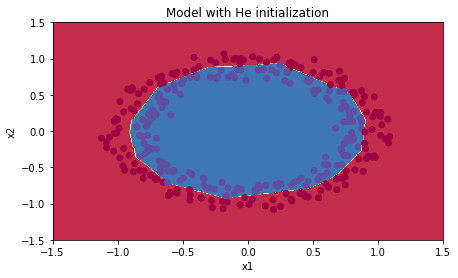

In [52]:
plt.title("Model with He initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.reshape(train_Y.shape[1]))

The model with He initialization separates the blue and the red dots very well in a small number of iterations